In [1]:
!pwd

/home/alma.andersson/eggplant/notebooks


In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
from scipy.spatial.distance import cdist

import anndata as ad
import pandas as pd
import sys

import eggplant as eg

    
import os.path as osp
import os
from PIL import Image

In [3]:
MAIN_DIR = "/data/alma.andersson/eggplant/data"
CNT_PTHS = ["developmental-heart/w_10/anndata/V10F24-105_A1.h5ad",
            "developmental-heart/w_10/anndata/V10F24-105_B1.h5ad",
            "developmental-heart/w_10/anndata/V10F24-105_C1.h5ad",
            "developmental-heart/w_10/anndata/V10F24-105_D1.h5ad",
           ]
CNT_PTHS = [osp.join(MAIN_DIR,p) for p in CNT_PTHS]

In [31]:
REF_DIR = "/home/alma/w-projects/ccf/rsc/ref/dev-heart"
REF_DIR = "/data/alma.andersson/eggplant/references/w_10/dev-heart"

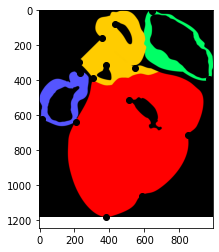

In [42]:
ref_img = Image.open(osp.join(REF_DIR,"dev-heart-black-002.png"))
ref_lmk = pd.read_csv(osp.join(REF_DIR,"dev-heart_landmarks.tsv"),sep="\t",header = 0,index_col=0)

plt.imshow(ref_img)
plt.scatter(ref_lmk.x_coord,ref_lmk.y_coord,c = "black")


In [43]:
grid_crd,mta = eg.pp.reference_to_grid(ref_img,
                                       n_approx_points=10000,
                                       n_regions=4,
                                       background_color = "black",
                                      )

In [34]:
n_lmk = ref_lmk.shape[0]
lmk_cmap = {0:"blue",1:"red",2:"green",3:"yellow",4:"magenta"}

In [46]:
mta_cmap = {0:"red",1:"green",2:"blue",3:"darkblue"}

In [36]:
n_lmk

15

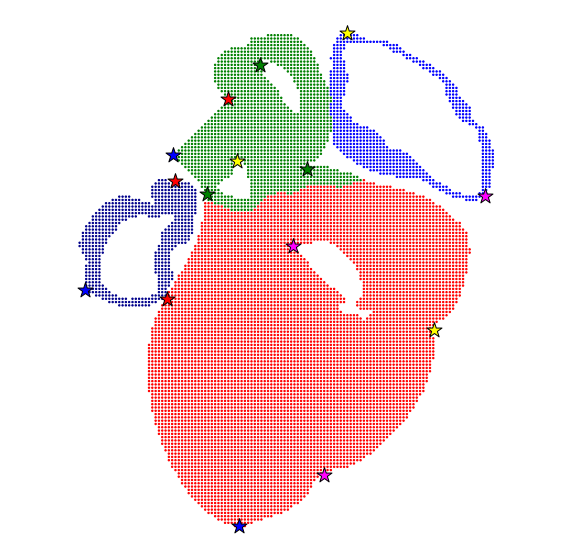

In [47]:
plt.figure(figsize=(10,10),facecolor ="white")
plt.scatter(grid_crd[:,0],
            grid_crd[:,1],
            c = [mta_cmap[x] for x in mta],s = 2)

plt.axis("equal")
plt.axis("off")
for ii in range(n_lmk):
    plt.scatter(ref_lmk.x_coord.values[ii],
                ref_lmk.y_coord.values[ii],
                c = lmk_cmap[ii % len(lmk_cmap)],
                marker = "*",
                edgecolor ="black",
                s = 250,
               )

plt.gca().invert_yaxis()
plt.show()

In [12]:
!export CUDA_VISIBLE_DEVICES=0 

In [60]:
ref = eg.m.Reference(grid_crd,
                     landmarks = ref_lmk.values,
                      meta = dict(region = mta),
                    )

In [14]:
adatas = [ad.read_h5ad(p) for p in CNT_PTHS]


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [15]:
for a in adatas:
    print(a)

AnnData object with n_obs × n_vars = 2169 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'curated_landmarks', 'spatial'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 2246 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'curated_landmarks', 'spatial'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 2250 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'curated_landmarks', 'spatial'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 2513 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'curated_landmarks', 'spatial'
    obsm: 'spatial'


In [16]:
adatas = {f"dh{l}":adatas[k] for k,l in enumerate(["A","B","C","D"])}#,"dhB":adatas[1]}

In [17]:
columns = ["x_coord","y_coord"]
for key in adatas.keys():
    n_lmk_a = adatas[key].uns["curated_landmarks"].shape[0]
    index = [f"L{k}" for k in range(n_lmk_a)]
    adatas[key].uns["curated_landmarks"] = pd.DataFrame(adatas[key].uns["curated_landmarks"],
                                                       columns = columns,
                                                        index = index,
                                                       )

In [18]:
for adata in adatas.values():
    # standard normalization steps
    sc.pp.filter_genes(adata,
                       min_cells = 0.1)
    
    sc.pp.normalize_total(adata,1e4,
                          exclude_highly_expressed = True)
    sc.pp.log1p(adata)
    sc.pp.scale(adata)
    #--- eggplant specific pre-processing---
    # match scales
    eg.pp.match_scales(adata,ref)
    # perform TPS warping and calculate landmark distances
    eg.pp.get_landmark_distance(adata,
                                reference=ref)



/home/alma.andersson/miniconda3/envs/eggplant/lib/python3.8/site-packages/pandas-1.3.1-py3.8-linux-x86_64.egg/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


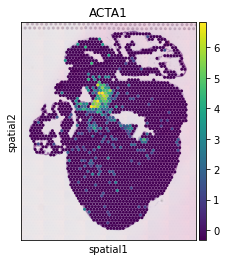

In [27]:
sc.pl.spatial(adatas["dhA"],color ="ACTA1",size=0.4e-4)

In [62]:
ref.clean()

In [ ]:
np.random.seed(1337)
genes = ["MYH6","ELN","MYH7","ACTA1","COL2A1"]
idx = np.random.choice(len(adatas["dhA"]),
                       replace = False,
                       size = 1500)

losses = eg.fun.transfer_to_reference(adatas,
                                      genes,
                                      ref,
                                      n_epochs=1000,
                                      device ="gpu",
                                      verbose = True,
                                      return_losses = True,
                                      return_models =False,
                                      max_cg_iterations = 10000,
                                      )

Processing >> Model : dhA | Feature : MYH6


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:34<00:00, 29.02it/s]


Processing >> Model : dhA | Feature : ELN


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:34<00:00, 29.18it/s]


Processing >> Model : dhA | Feature : MYH7


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.42it/s]


Processing >> Model : dhA | Feature : ACTA1


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.52it/s]


Processing >> Model : dhA | Feature : COL2A1


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 30.29it/s]


Processing >> Model : dhB | Feature : MYH6


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 29.89it/s]


Processing >> Model : dhB | Feature : ELN


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 29.83it/s]


Processing >> Model : dhB | Feature : MYH7


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 29.98it/s]


Processing >> Model : dhB | Feature : ACTA1


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 29.89it/s]


Processing >> Model : dhB | Feature : COL2A1


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.41it/s]


Processing >> Model : dhC | Feature : MYH6


100%|███████████████████████████████████████████████████████████████████████████| 1000/1000 [00:33<00:00, 30.16it/s]


Processing >> Model : dhC | Feature : ELN


 30%|██████████████████████▉                                                     | 302/1000 [00:10<00:23, 30.18it/s]

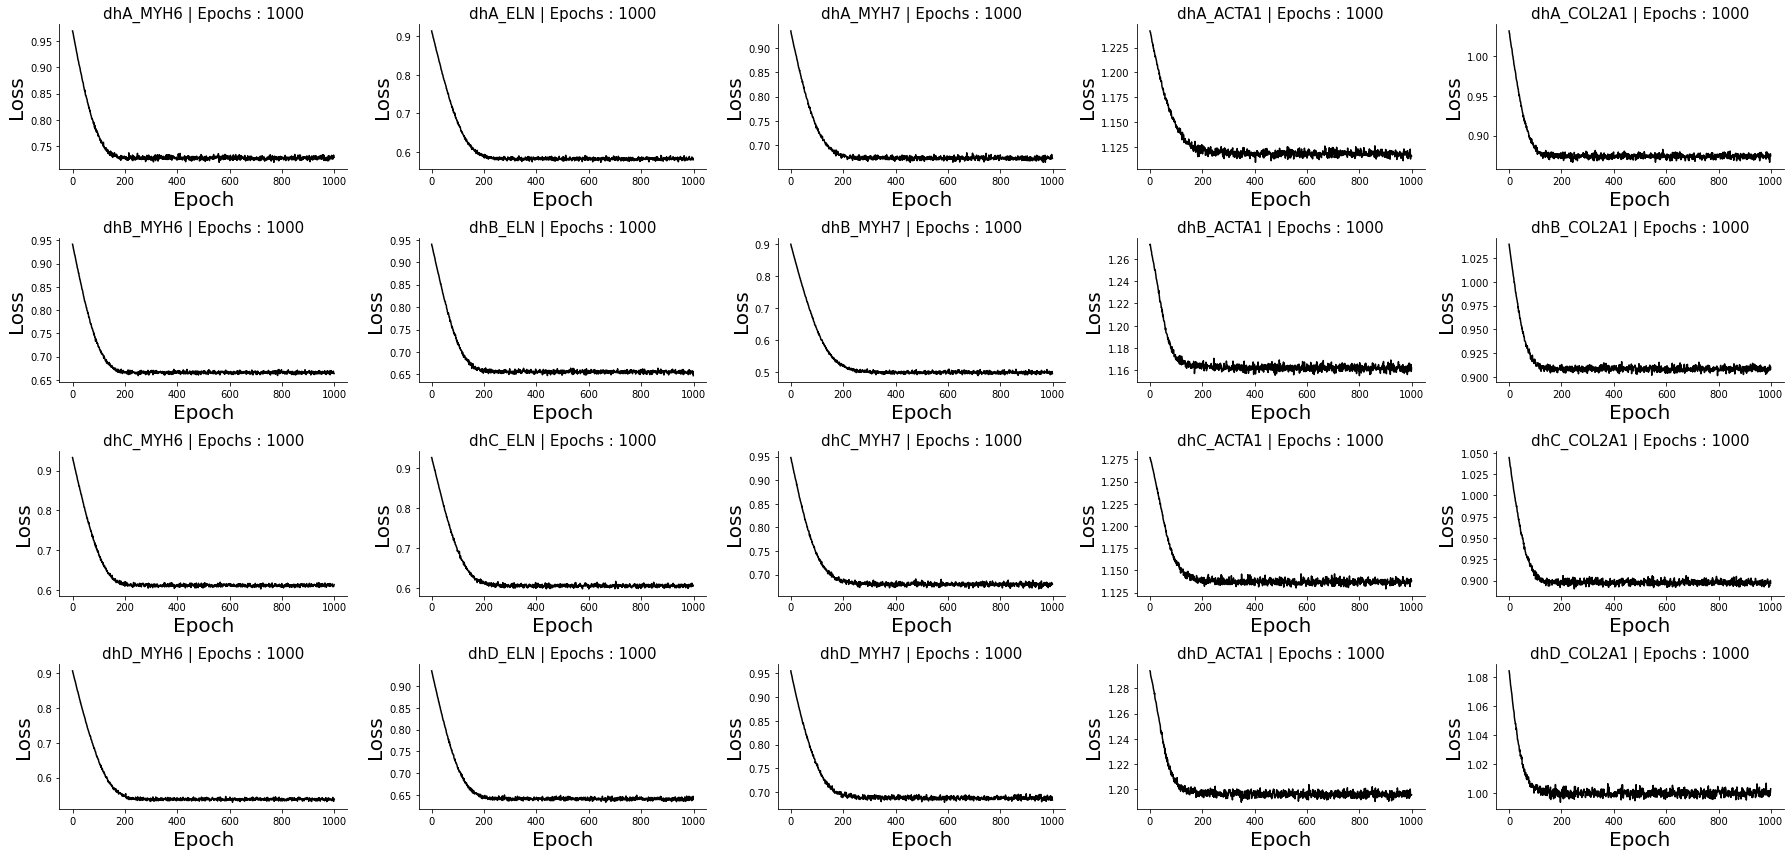

In [50]:
eg.pl.model_diagnostics(losses = losses)

In [51]:
import copy
ref2 = copy.deepcopy(ref)

In [52]:
feats = ref2.adata.var["feature"].values
uni_feat = np.unique(feats)
new_X = np.zeros((len(ref2.adata),len(uni_feat)))
for k,f in enumerate(uni_feat):
    new_X[:,k] = ref.adata.X[:,feats == f].mean(axis=1)
    
new_var = pd.DataFrame(uni_feat,
                       index = ["Average {}".format(x) for x in uni_feat],
                       columns = ["feature"],
                      )
new_adata = ad.AnnData(new_X,
                       var = new_var,
                       obs = ref2.adata.obs,
                      )

ref2.adata = new_adata

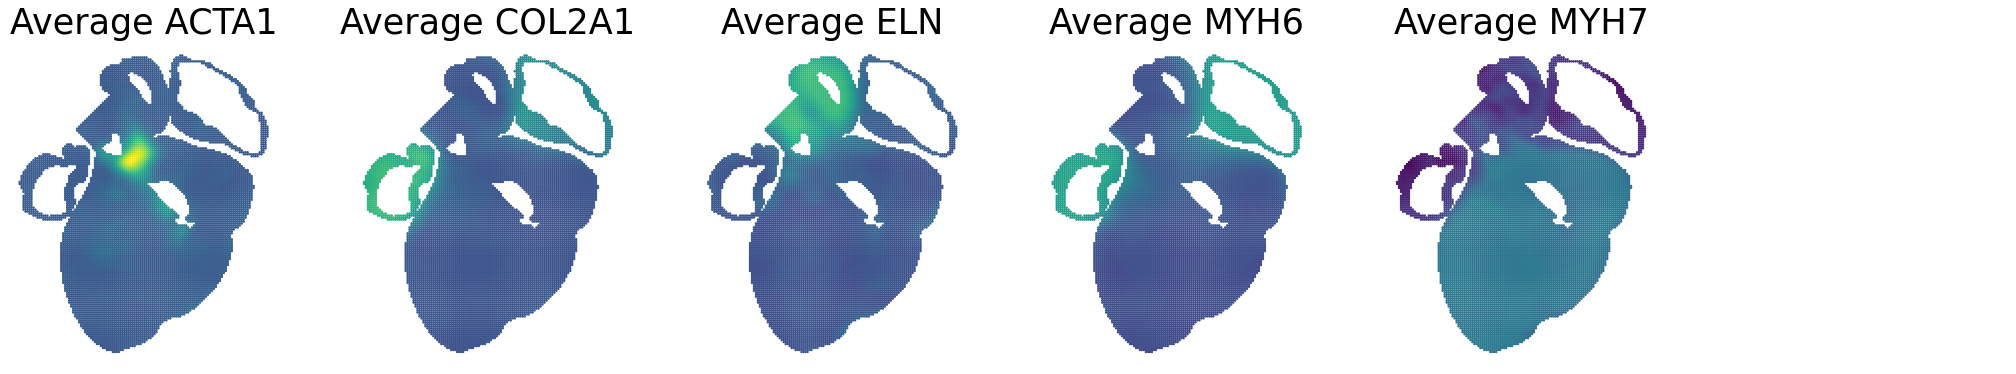

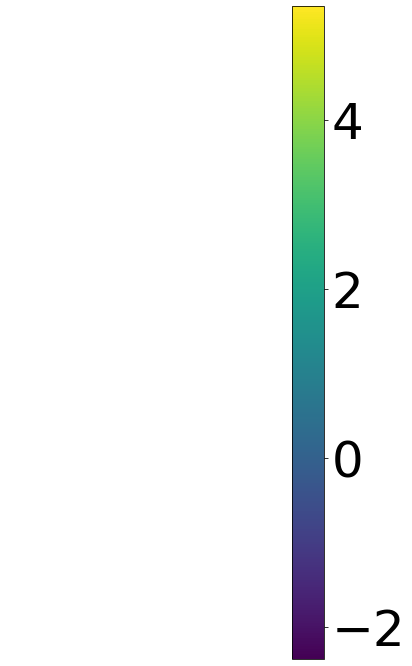

In [55]:
eg.pl.visualize_transfer(ref2,
                         n_cols = 6,
                         side_size = 6,
                         quantile_scaling = False,
                         flip_y = True,
                         show_landmarks = False,
                         marker_size = 2,
                         include_colorbar = True,
                         separate_colorbar = True,
                         fontsize = 35,
                        )

In [59]:
ref.adata.obs.region = mta

ValueError: Length of values (9852) does not match length of index (9850)

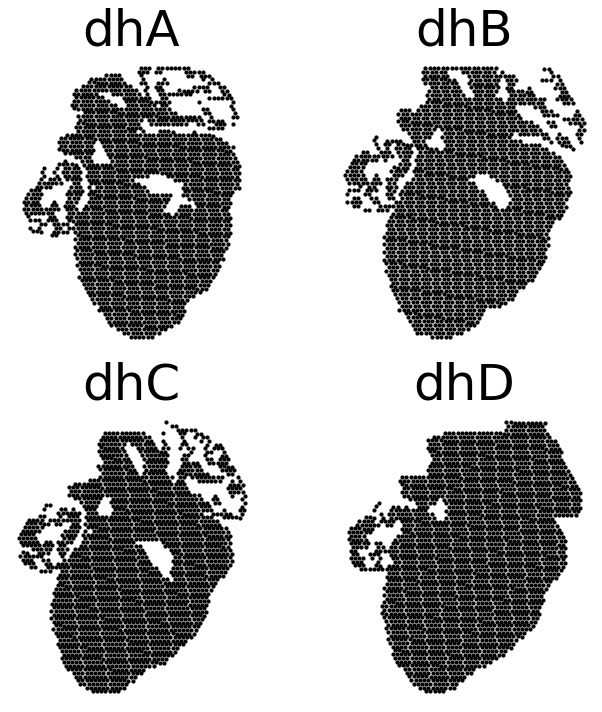

In [112]:
fig,ax = plt.subplots(2,2,figsize = (10,10))
ax = ax.flatten()
for k,(name,_adata) in enumerate(adatas.items()):
    ax[k].scatter(_adata.obsm["spatial"][:,0],
                  _adata.obsm["spatial"][:,1],
                  s = 10,
                  marker = "o",
                  #c = _adata.obs_vector("MYH10"),
                  c = "black",
                 )
    ax[k].axis("off")
    ax[k].set_title(name,fontsize = 50)
    ax[k].invert_yaxis()
    ax[k].set_aspect("equal")
    
fig.tight_layout()
    
    

In [ ]:
import matplotlib

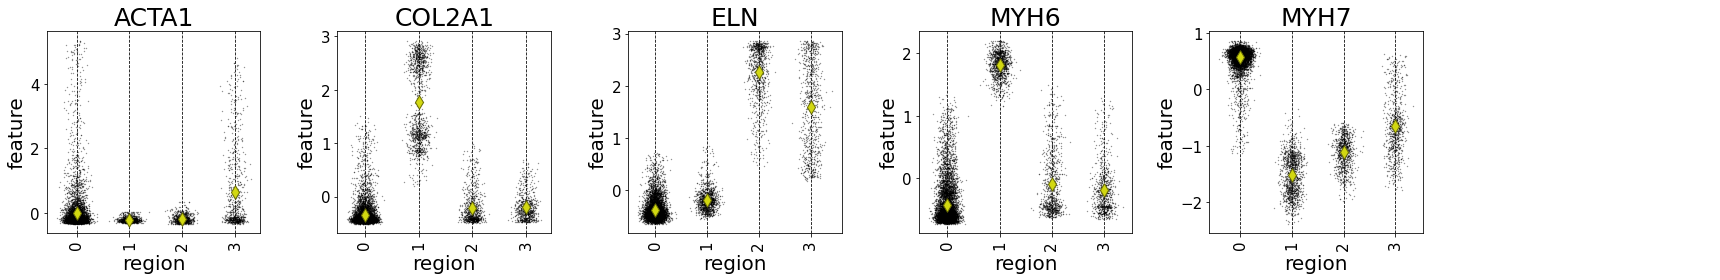

In [56]:
outside = {"attribute":"var","column":"feature"}
inside = {"attribute":"obs","column":"region"}
eg.pl.swarmplot_transfer(ref,
                       inside,
                       outside,
                       return_figure=False,
                       n_cols = 6,
                        )